In [1]:
import rateStudy
import numpy as np
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.23/01


## 1. Print log(N) - log(S) curve

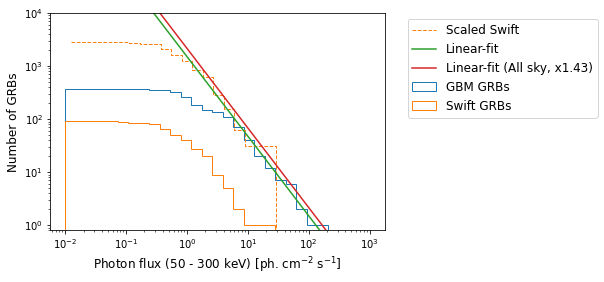

In [2]:
logNlogS = rateStudy.fit_logNlogS_curve(plotting=True)

## 2. Synthesize bursts based on the log N - log S curve.

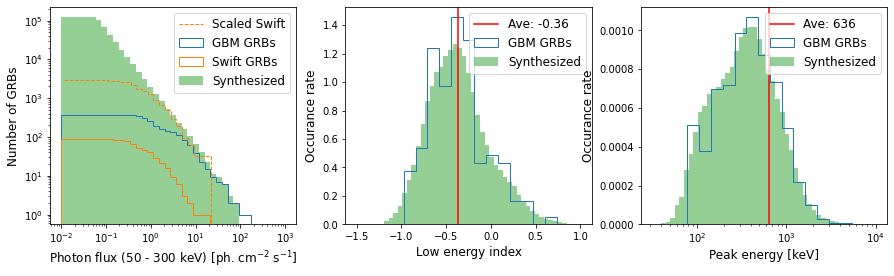

In [3]:
table = rateStudy.generate_bursts(logNlogS, plotting=True)

## 3. Loading instrument IRFs and backgrounds

In [2]:
inst = rateStudy.make_table(eff = "./AMEGO-X/uptodate/noLowHits_Aeff_Cos0.8_UC.txt", bkg = "./AMEGO-X/bg_rates_pixel_250um.root")

In [3]:
inst

E_low,E_high,EA,background
float64,float64,float64,float64
0.079,0.1,5.718999999999999,2.2716666666666665
0.1,0.125,29.351499999999998,20.871388888888887
0.125,0.158,87.1115,50.975833333333334
0.158,0.199,174.9105,61.799166666666665
0.199,0.251,283.194,52.754444444444445
0.251,0.316,398.712,46.61666666666666
0.316,0.398,488.4125,38.92111111111112
0.398,0.501,532.9395,34.52222222222221
0.501,0.63,537.651,37.13861111111111


## 4. Estimate the GRB rate

In [5]:
#er = rateStudy.EstimateRate(inst)
er = rateStudy.EstimateRate(load_status="current")

### 4.1 Single run

In [7]:
output = er.forward_folding(verbose=True, return_output=True)

[Log] Generating burst spectra



[Log] Forward folding the burst spectra



[Log] Analysis done. Estimated rate is 49.1 GRBs/yr (SNR > 6.5)


### 4.2 Multiple runs

In [5]:
er.simulation(runs=3)


[Log] Analysis Done (status: 'current'). The rate is 52.0 +/- 5.6 GRBs/yr


### 4.3 Single site rate

In [3]:
single_site = {"E_low": 0.025, "E_high": 0.1, "EA": 3550, "background": 25577}

In [5]:
output = er.forward_folding(inst_table=single_site, verbose=True, return_output=True)

[Log] Forward folding the burst spectra



[Log] Analysis done. Estimated rate is 103.5 GRBs/yr (SNR > 6.5)


In [6]:
er.simulation(runs=3, inst_table=single_site, save_status="single")


[Log] Analysis Done (status: 'single'). The rate is 113.2 +/- 5.3 GRBs/yr


### 4.4 Multiple trigger flags

In [7]:
single_site = {"E_low": 0.025, "E_high": 0.1, "EA": 3550, "background": 25577}

bursts = er.create_spectra()
out_normal = er.forward_folding(burst_table=bursts, return_output=True)
out_single = er.forward_folding(burst_table=bursts, inst_table=single_site, return_output=True)

In [17]:
print("Compton (SNR > 6.5): {:.1f} GRBs/yr".format(er.calc_rate(out_normal["snr"], snr_cut = 6.5)))
print("Compton (SNR > 5) AND single-site (SNR >5): {:.1f} GRBs/yr ".format(sum((out_single["snr"]>5)*(out_normal["snr"]>5))*er.FoV))

Compton (SNR > 6.5): 57.7 GRBs/yr
Compton (SNR > 5) AND single-site (SNR >5): 71.2 GRBs/yr 


In [18]:
from tqdm.notebook import trange
rate1 = []
rate2 = []
single_site = {"E_low": 0.025, "E_high": 0.1, "EA": 3550, "background": 25577}

for i in trange(100):
    bursts = er.create_spectra()
    out_normal = er.forward_folding(burst_table=bursts, return_output=True)
    out_single = er.forward_folding(burst_table=bursts, inst_table=single_site, return_output=True)
    rate1.append(er.calc_rate(out_normal["snr"], snr_cut = 6.5))
    rate2.append(sum((out_single["snr"]>5)*(out_normal["snr"]>5))*er.FoV)

rate1 = np.asarray(rate1)
rate2 = np.asarray(rate2)

print("Compton (SNR > 6.5): {:.1f} +/- {:.1f} GRBs/yr".format(np.average(rate1), np.std(rate1))
print("Compton + Single site (SNR > 5): {:.1f} GRBs/yr".format(np.average(rate2), np.std(rate2))
np.save("./output/Trig1", rate1)
np.save("./output/Trig2", rate2)

Compton (SNR > 6.5): 48.6 +/- 7.0 GRBs/yr
Compton + Single site (SNR > 5): 59.5 +/- 8.7 GRBs/yr


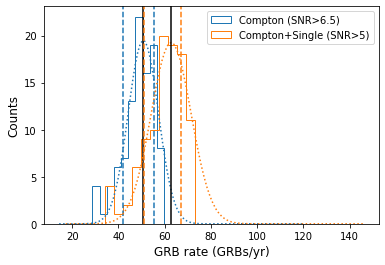

In [9]:
rate1 = np.load("./output/Trig1.npy")
rate2 = np.load("./output/Trig2.npy")

rateStudy.EstimateRate.plotRateHist(rate1, label="Compton (SNR>6.5)")
rateStudy.EstimateRate.plotRateHist(rate2, label="Compton+Single (SNR>5)")

print("Compton (SNR > 6.5): {:.1f} +/- {:.1f} GRBs/yr".format(np.average(rate1), np.std(rate1)))
print("Compton + Single site (SNR > 5): {:.1f} +/- {:.1f} GRBs/yr".format(np.average(rate2), np.std(rate2)))